In [77]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp

params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm
import glob

In [78]:
projectDir='/jukebox/norman/amennen/prettymouth/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

In [79]:
# load subject numbers
subInd = 0
nsub=38
allnames = []
allgroups = []
groupInfo={}
# skip subjects 039 and 116
with open(projectDir + 'participants.tsv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if 'sub' in row[0]:
            # now skip the subjects we don't want to analyze
            allInfo = row[0].split('\t')
            subjName=allInfo[0]
            if subjName != 'sub-039' and subjName != 'sub-116':
                if allInfo[3] == 'paranoia':
                    group = 0
                elif allInfo[3] == 'affair':
                    group = 1
                allnames.append(subjName)
                allgroups.append(group)
                subInd+=1

In [80]:
paranoidSubj = allnames[0:19]
cheatingSubj = allnames[19:]
paranoidLabel = allgroups[0:19]
cheatingLabel = allgroups[19:]
nfolds=19
print(allnames)
segment_score_vector = np.load('segment_score_vector.npy')
beliefs_vector = np.load('beliefs_vector.npy')
emotions_vector = np.load('emotions_vector.npy')
intentions_vector = np.load('intentions_vector.npy')

['sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-068', 'sub-081', 'sub-112', 'sub-053', 'sub-113', 'sub-031', 'sub-114', 'sub-115', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122']


In [81]:
# load all the possible
n_options = 105
all_k1 = np.zeros((n_options))
all_k2 = np.zeros((n_options))
all_filters = np.zeros((n_options))
all_removeAvg = np.zeros((n_options))
all_masks = np.zeros((n_options))
with open('array_combinations.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        #print(row)
        if line_count > 0:
            i=np.int(row[0])
            all_k1[i-1]=np.int(row[1])
            all_k2[i-1]=np.int(row[2])
            all_filters[i-1]=np.int(row[3])
            all_removeAvg[i-1]=np.int(row[4])
            all_masks[i-1]=np.int(row[5])
        line_count += 1

In [84]:
all_masks
# only take the ROIs for that one
ROI = 2
ind_ROI = np.argwhere(all_masks==ROI)
perm_vals = ind_ROI + 1
if ROI == 0:
    all_ROI_ind = perm_vals[:,0]
else:
    all_ROI_ind = np.concatenate((np.arange(1,70),perm_vals[:,0]),axis=0)
len(all_ROI_ind)

81

In [85]:
# now see how many have finished if exists, ploy
n_options = len(all_ROI_ind)
iterations_completed = []
classifierType = 2
lowhigh = 0
for ii in np.arange(n_options):
    perm = all_ROI_ind[ii]
    index=perm-1
    k1 = np.int(all_k1[index])
    k2 = np.int(all_k2[index])
    filterType = np.int(all_filters[index])
    if perm < 70:
        fn_type = glob.glob('new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '*_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy')
        filename_data = fn_type[0]
        #filename_data = 'new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'
        
        #print(filename_data)
    else:
        filename_data = 'new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_1' +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'
        #print(filename_data)
    if os.path.isfile(filename_data):
        print('ITERATION %i FOUND' % perm)
        iterations_completed.append(ii)
        all_accuracies = np.load(filename_data) # this is 450 TRs x 1000 examples
    else:
        print('ITERATION %i NOT FOUND' % perm)
print('*************************************************')
print('ITERATIONS COMPLETED:')
print(iterations_completed)
n_completed = len(iterations_completed)
print('number completed: %i/%i' % (n_completed,n_options))

ITERATION 1 FOUND
ITERATION 2 FOUND
ITERATION 3 FOUND
ITERATION 4 FOUND
ITERATION 5 FOUND
ITERATION 6 FOUND
ITERATION 7 FOUND
ITERATION 8 FOUND
ITERATION 9 FOUND
ITERATION 10 FOUND
ITERATION 11 FOUND
ITERATION 12 FOUND
ITERATION 13 FOUND
ITERATION 14 FOUND
ITERATION 15 FOUND
ITERATION 16 FOUND
ITERATION 17 FOUND
ITERATION 18 FOUND
ITERATION 19 FOUND
ITERATION 20 FOUND
ITERATION 21 FOUND
ITERATION 22 FOUND
ITERATION 23 FOUND
ITERATION 24 FOUND
ITERATION 25 FOUND
ITERATION 26 FOUND
ITERATION 27 FOUND
ITERATION 28 FOUND
ITERATION 29 FOUND
ITERATION 30 FOUND
ITERATION 31 FOUND
ITERATION 32 FOUND
ITERATION 33 FOUND
ITERATION 34 FOUND
ITERATION 35 FOUND
ITERATION 36 FOUND
ITERATION 37 FOUND
ITERATION 38 FOUND
ITERATION 39 FOUND
ITERATION 40 FOUND
ITERATION 41 FOUND
ITERATION 42 FOUND
ITERATION 43 FOUND
ITERATION 44 FOUND
ITERATION 45 FOUND
ITERATION 46 FOUND
ITERATION 47 FOUND
ITERATION 48 FOUND
ITERATION 49 FOUND
ITERATION 50 FOUND
ITERATION 51 FOUND
ITERATION 52 FOUND
ITERATION 53 FOUND
IT

In [86]:
# now for the ones that have been completed:
# 1. average accuracy over 1000 samples
# 2. average accuracy over all TRs
# 3. plot
# 4. determine which one has the best one
n_completed = len(iterations_completed)
nTR = 450
n_iter = 1000
all_accuracy_data = np.zeros((n_iter,n_completed))
for cc in np.arange(n_completed):
    perm = all_ROI_ind[cc]
    index=perm-1
    k1 = np.int(all_k1[index])
    k2 = np.int(all_k2[index])
    filterType = np.int(all_filters[index])
    if perm < 70:
        #filename_data = 'new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'
        fn_type = glob.glob('new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '*_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy')
        filename_data = fn_type[0]
    else:
        filename_data = 'new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_1' +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'

    all_accuracies = np.load(filename_data) # this is 450 TRs x 1000 examples
    all_accuracy_data[:,cc] = all_accuracies

# all_accuracy_data is 1000 iterations x number of types completed

In [87]:
# now plot mean over all TRs in order from best to worst
total_average = np.mean(all_accuracy_data,axis=0)
large_small_ind = np.argsort(total_average)[::-1] # this is the indexes form all the ones that have been completed
ACC_average_sorted = all_accuracy_data[:,large_small_ind]
total_average_sorted = total_average[large_small_ind]
print('the best classification accuracy is %4.4f' % total_average_sorted[0])

the best classification accuracy is 0.8145


In [88]:
# now plot
# there's 1000 accuracy scores per each combo -- each accuracy score is an iteration of leave one out classification
data_acc_vector = ACC_average_sorted.flatten()
iter_number = np.repeat(np.arange(n_iter),n_completed)
combo = np.tile(np.arange(n_completed),n_iter)
#datanull = np.repeat(np.arange(2),n_combo*n_iter)
all_data = np.concatenate((data_acc_vector[:,np.newaxis],iter_number[:,np.newaxis],combo[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=all_data, columns=['accuracy',  'iter', 'combo'])

Text(0.5,1,'Mean accuracy over all classifier types')

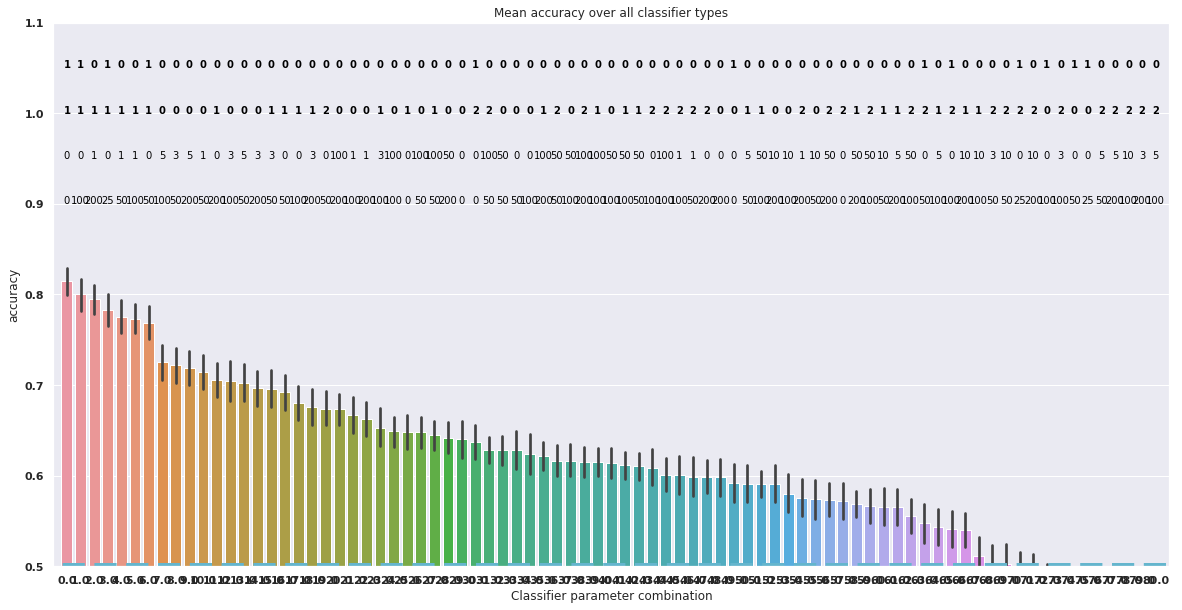

In [89]:
sns.set(font_scale=1)

plt.figure(figsize=(20,10))
pl = sns.barplot(data=df,x="combo",y="accuracy",ci=95)
#sns.stripplot(data=df,x="combo",y="accuracy",jitter=True,split=True,hue="datanull",color="k")
#sns.violinplot(data=df,x="combo",y="accuracy",hue="datanull",split=True)
for i in np.arange(n_completed):
    perm = all_ROI_ind[large_small_ind[i]]
    c_index = perm - 1
    #c_index = iterations_completed[large_small_ind[i]]
    k1 = np.int(all_k1[c_index])
    k2 = np.int(all_k2[c_index])
    filterType = np.int(all_filters[c_index])
    wasAvgRemove = np.int(all_removeAvg[c_index])
    combo_k1k2 = [k1,k2]
    str_avg = '%2.2f' % total_average_sorted[i]
    pl.text(i, 1.05, str(wasAvgRemove), horizontalalignment='center', size='small', color='black',weight='bold')
    #pl.text(i, total_average_sorted[i]+0.1, str_avg, horizontalalignment='center', size='small', color='black', weight='light')
    pl.text(i, 1, str(filterType), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, 0.95, str(k1), horizontalalignment='center', size='small', color='black',weight='light')
    pl.text(i, 0.9, str(k2), horizontalalignment='center', size='small', color='black',weight='light')

plt.plot([-10 ,n_completed+5], [.5, .5], 'c--', lw=6)
plt.xlim([-1,n_completed])
plt.ylim([0.5,1.1])
plt.xlabel('Classifier parameter combination')
plt.title('Mean accuracy over all classifier types')